In [ ]:
import os
import random
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
import tensorflowjs as tfjs
import numpy as np

In [14]:
base_dir = r"D:\Random_Projects\IDCamp\Proyek 2"
categories = ["cat", "dog", "spider"]
category_counts = {category: len(os.listdir(os.path.join(base_dir, category))) for category in categories}
print("Initial Image Counts:", category_counts)
min_count = min(category_counts.values())
print(f"Balancing dataset to {min_count} images per category")

Initial Image Counts: {'cat': 4705, 'dog': 7790, 'spider': 4821}
Balancing dataset to 4705 images per category


In [ ]:
#Create balanced dataset folder to train a CNNmodel
balanced_dir = os.path.join(base_dir, "balanced")
os.makedirs(balanced_dir, exist_ok=True)
for category in categories:
    source_path = os.path.join(base_dir, category)
    dest_path = os.path.join(balanced_dir, category)
    os.makedirs(dest_path, exist_ok=True)
    selected_files = random.sample(os.listdir(source_path), min_count)
    for file in selected_files:
        shutil.copy2(os.path.join(source_path, file), os.path.join(dest_path, file))
print("Dataset balanced!")

Dataset balanced!


In [6]:
#Split into train, val, test (80:10:10, try different ratios later)
split_ratios = {"train": 0.8, "val": 0.1, "test": 0.1}
split_dirs = {key: os.path.join(base_dir, key) for key in split_ratios}

for key in split_dirs.values():
    os.makedirs(key, exist_ok=True)
    for category in categories:
        os.makedirs(os.path.join(key, category), exist_ok=True)

for category in categories:
    files = os.listdir(os.path.join(balanced_dir, category))
    random.shuffle(files)
    train_split = int(split_ratios["train"] * min_count)
    val_split = int(split_ratios["val"] * min_count)
    train_files = files[:train_split]
    val_files = files[train_split:train_split + val_split]
    test_files = files[train_split + val_split:]
    
    for split, split_files in zip(["train", "val", "test"], [train_files, val_files, test_files]):
        for file in split_files:
            shutil.copy2(os.path.join(balanced_dir, category, file), os.path.join(base_dir, split, category, file))
print("Train, Val, Test split completed!")

Train, Val, Test split completed!


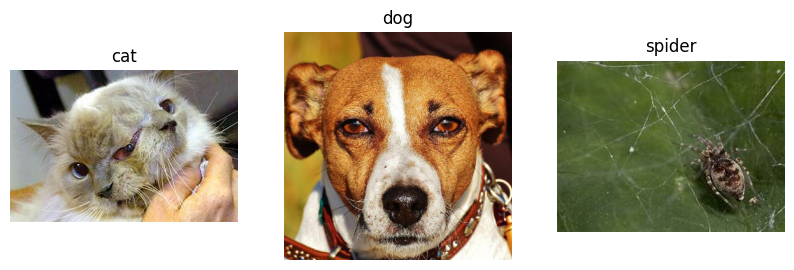

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
for ax, category in zip(axes, categories):
    sample_image = random.choice(os.listdir(os.path.join(base_dir, "train", category)))
    img = plt.imread(os.path.join(base_dir, "train", category, sample_image))
    ax.imshow(img)
    ax.set_title(category)
    ax.axis("off")

plt.show()

In [ ]:
#Image Resolutions Used
train_dir = r"D:\Random_Projects\IDCamp\Proyek 2\train"
image_data = []

for category in ["cat", "dog", "spider"]:
    category_path = os.path.join(train_dir, category)
    
    for file in os.listdir(category_path):
        img_path = os.path.join(category_path, file)
        img = cv2.imread(img_path)
        
        if img is not None:
            height, width, _ = img.shape
            image_data.append({"Category": category, "Filename": file, "Width": width, "Height": height})

imageSizeDf = pd.DataFrame(image_data)
print(imageSizeDf.head())
print(imageSizeDf.groupby("Category")[["Width", "Height"]].describe())

  Category   Filename  Width  Height
0      cat     1.jpeg    300     210
1      cat   100.jpeg    150     150
2      cat  1002.jpeg    200     300
3      cat  1004.jpeg    300     200
4      cat  1005.jpeg    300     200
           Width                                                              \
           count        mean         std    min    25%    50%    75%     max   
Category                                                                       
cat       3764.0  494.856536  395.250717  107.0  300.0  512.0  512.0  6720.0   
dog       3764.0  369.734591  113.923610  137.0  300.0  300.0  512.0   512.0   
spider    3764.0  309.135494   85.357538   88.0  300.0  300.0  300.0   640.0   

          Height                                                              
           count        mean         std    min    25%    50%    75%     max  
Category                                                                      
cat       3764.0  458.828640  312.780160   75.0  300.0  512.

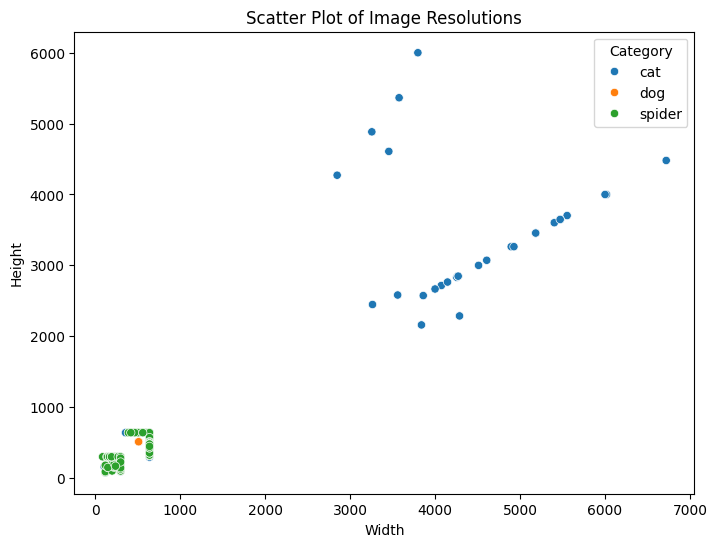

In [3]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=imageSizeDf, x="Width", y="Height", hue="Category")
plt.title("Scatter Plot of Image Resolutions")
plt.xlabel("Width")
plt.ylabel("Height")
plt.legend(title="Category")
plt.show()

In [2]:
base_dir = r"D:\Random_Projects\IDCamp\Proyek 2"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

IMG_SIZE = (128, 128)  #Resize images for uniformity
BATCH_SIZE = 32 #Batch Size for training

#Augment data for more variatioins of train data
train_datagen = ImageDataGenerator(
    rescale=1.0/255, 
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

#Class Indices
class_names = list(train_generator.class_indices.keys())
print("Class Labels:", class_names)

Found 11292 images belonging to 3 classes.
Found 1410 images belonging to 3 classes.
Found 1413 images belonging to 3 classes.
Class Labels: ['cat', 'dog', 'spider']


In [3]:
#CNN Model
model = Sequential([
    Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

#Scheduler to reduce lr if validation loss stops improving for 3 epochs
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 128)      512       
 hNormalization)                                                 
                                                        

In [4]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[lr_scheduler]
)

Epoch 1/50
353/353 [==============================] - 64s 162ms/step - loss: 1.3274 - accuracy: 0.4790 - val_loss: 0.8179 - val_accuracy: 0.6404 - lr: 5.0000e-04
Epoch 2/50
353/353 [==============================] - 53s 151ms/step - loss: 0.9067 - accuracy: 0.5705 - val_loss: 0.6849 - val_accuracy: 0.6787 - lr: 5.0000e-04
Epoch 3/50
353/353 [==============================] - 54s 153ms/step - loss: 0.8381 - accuracy: 0.6185 - val_loss: 0.9254 - val_accuracy: 0.6043 - lr: 5.0000e-04
Epoch 4/50
353/353 [==============================] - 55s 157ms/step - loss: 0.7582 - accuracy: 0.6664 - val_loss: 0.7420 - val_accuracy: 0.6858 - lr: 5.0000e-04
Epoch 5/50
353/353 [==============================] - 56s 158ms/step - loss: 0.6928 - accuracy: 0.6993 - val_loss: 0.5690 - val_accuracy: 0.7532 - lr: 5.0000e-04
Epoch 6/50
353/353 [==============================] - 57s 160ms/step - loss: 0.6397 - accuracy: 0.7302 - val_loss: 0.4441 - val_accuracy: 0.8199 - lr: 5.0000e-04
Epoch 7/50
353/353 [========

In [5]:
#Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

45/45 [==============================] - 3s 64ms/step - loss: 0.1656 - accuracy: 0.9413
Test Accuracy: 0.9413
Test Loss: 0.1656


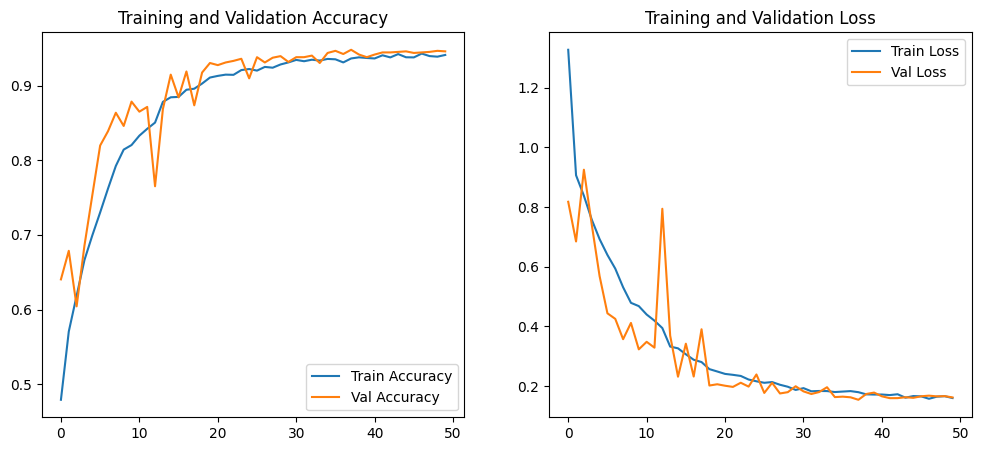

In [6]:
def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()
plot_history(history)

In [7]:
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
#MobileNetV2 transfer learning + CNN
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  
cnn_layers = Sequential([
    Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    
    Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    
    Conv2D(1024, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
])
model2 = Sequential([
    base_model,  
    cnn_layers,

    Flatten(),
    Dense(1024, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 sequential_1 (Sequential)   (None, 2, 2, 1024)        7677312   
                                                                 
 flatten_1 (Flatten)         (None, 4096)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              4195328   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 3)                 3075      
                                                      

In [5]:
history = model2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[lr_scheduler]
)

Epoch 1/50
353/353 [==============================] - 169s 404ms/step - loss: 0.2809 - accuracy: 0.9175 - val_loss: 0.0764 - val_accuracy: 0.9794 - lr: 5.0000e-04
Epoch 2/50
353/353 [==============================] - 53s 149ms/step - loss: 0.1645 - accuracy: 0.9420 - val_loss: 0.0783 - val_accuracy: 0.9738 - lr: 5.0000e-04
Epoch 3/50
353/353 [==============================] - 52s 149ms/step - loss: 0.1501 - accuracy: 0.9450 - val_loss: 0.0926 - val_accuracy: 0.9723 - lr: 5.0000e-04
Epoch 4/50
353/353 [==============================] - 53s 150ms/step - loss: 0.1394 - accuracy: 0.9480 - val_loss: 0.0750 - val_accuracy: 0.9730 - lr: 5.0000e-04
Epoch 5/50
353/353 [==============================] - 54s 152ms/step - loss: 0.1256 - accuracy: 0.9528 - val_loss: 0.0875 - val_accuracy: 0.9752 - lr: 5.0000e-04
Epoch 6/50
353/353 [==============================] - 52s 148ms/step - loss: 0.1214 - accuracy: 0.9557 - val_loss: 0.1067 - val_accuracy: 0.9574 - lr: 5.0000e-04
Epoch 7/50
353/353 [=======

In [6]:
test_loss, test_acc = model2.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

45/45 [==============================] - 12s 272ms/step - loss: 0.0635 - accuracy: 0.9816
Test Accuracy: 0.9816
Test Loss: 0.0635


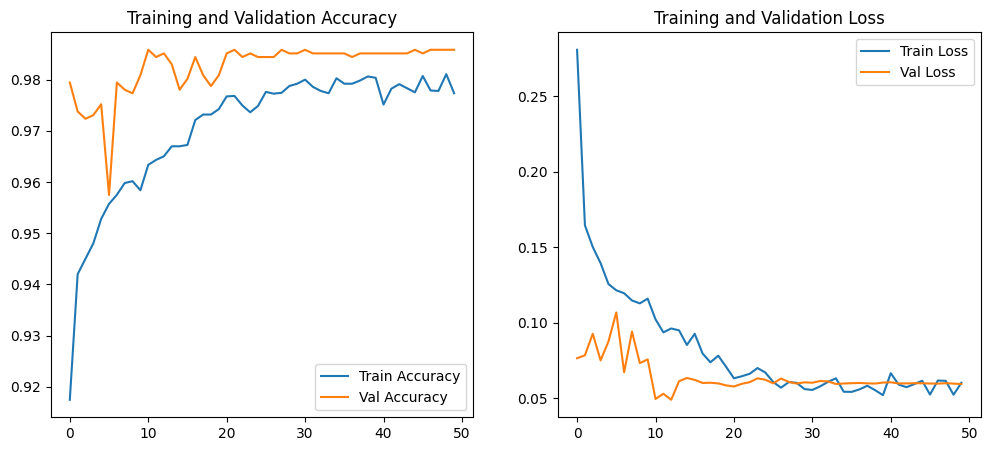

In [9]:
plot_history(history)

In [10]:
#MobileNetV2 transfer learning + CNN part 2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  
model3 = Sequential([
    base_model,
    
    Conv2D(128, (3,3), kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    Activation('relu'),

    GlobalAveragePooling2D(),  

    Dense(128, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

model3.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model3.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 128)         1474688   
                                                                 
 batch_normalization_8 (Batc  (None, 4, 4, 128)        512       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 4, 4, 128)         0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 2, 2, 128)        0         
 2D)                                                             
                                                      

In [11]:
history = model3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[lr_scheduler]
)

Epoch 1/50
353/353 [==============================] - 58s 155ms/step - loss: 0.1978 - accuracy: 0.9269 - val_loss: 0.1083 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 2/50
353/353 [==============================] - 53s 150ms/step - loss: 0.1481 - accuracy: 0.9474 - val_loss: 0.0770 - val_accuracy: 0.9766 - lr: 0.0010
Epoch 3/50
353/353 [==============================] - 53s 149ms/step - loss: 0.1438 - accuracy: 0.9449 - val_loss: 0.0786 - val_accuracy: 0.9745 - lr: 0.0010
Epoch 4/50
353/353 [==============================] - 53s 149ms/step - loss: 0.1327 - accuracy: 0.9509 - val_loss: 0.0669 - val_accuracy: 0.9801 - lr: 0.0010
Epoch 5/50
353/353 [==============================] - 53s 151ms/step - loss: 0.1227 - accuracy: 0.9571 - val_loss: 0.0606 - val_accuracy: 0.9816 - lr: 0.0010
Epoch 6/50
353/353 [==============================] - 53s 150ms/step - loss: 0.1193 - accuracy: 0.9554 - val_loss: 0.0687 - val_accuracy: 0.9823 - lr: 0.0010
Epoch 7/50
353/353 [==============================] 

In [12]:
test_loss, test_acc = model3.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

45/45 [==============================] - 3s 56ms/step - loss: 0.0746 - accuracy: 0.9795
Test Accuracy: 0.9795
Test Loss: 0.0746


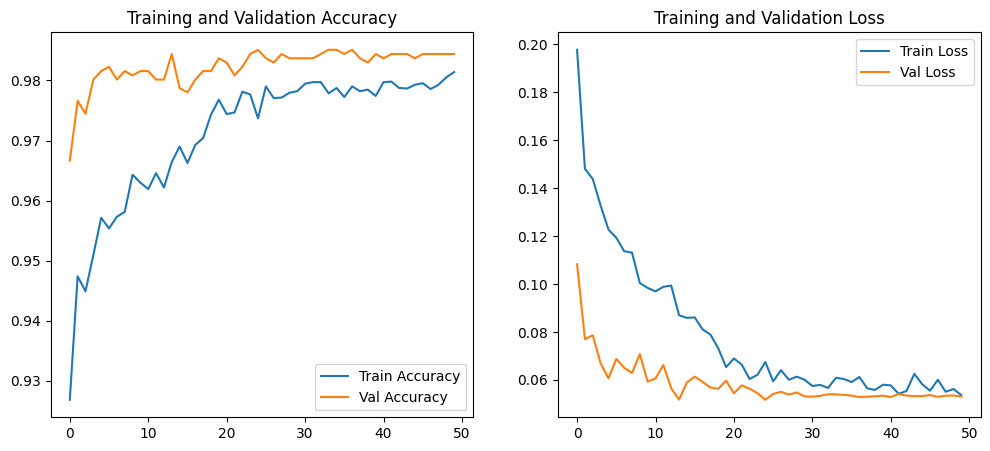

In [13]:
plot_history(history)

In [14]:
#SavedModel
model2.save(os.path.join(base_dir, "saved_model"))
print("Saved in SavedModel format")

INFO:tensorflow:Assets written to: D:\Random_Projects\IDCamp\Proyek 2\saved_model\assets


INFO:tensorflow:Assets written to: D:\Random_Projects\IDCamp\Proyek 2\saved_model\assets


Saved in SavedModel format


In [15]:
#TFLite
tflite_dir = os.path.join(base_dir, "tflite")
os.makedirs(tflite_dir, exist_ok=True)
converter = tf.lite.TFLiteConverter.from_keras_model(model2)
tflite_model = converter.convert()
with open(os.path.join(tflite_dir, "model.tflite"), "wb") as f:
    f.write(tflite_model)
print("Saved in TF-Lite format.")

#Save Label File for TFLite
class_labels = ["cat", "dog", "spider"]
label_path = os.path.join(tflite_dir, "label.txt")
with open(label_path, "w") as f:
    for label in class_labels:
        f.write(label + "\n")
print("Label file saved.")

INFO:tensorflow:Assets written to: C:\Users\FATHAN~1\AppData\Local\Temp\tmpw6axl3yz\assets


INFO:tensorflow:Assets written to: C:\Users\FATHAN~1\AppData\Local\Temp\tmpw6axl3yz\assets


Saved in TF-Lite format.
Label file saved.


In [16]:
#TensorFlow.js
tfjs_target_dir = os.path.join(base_dir, "tfjs_model")
tfjs.converters.save_keras_model(model2, tfjs_target_dir)
print("Model saved in TensorFlow.js format.")

Model saved in TensorFlow.js format.


### Inference

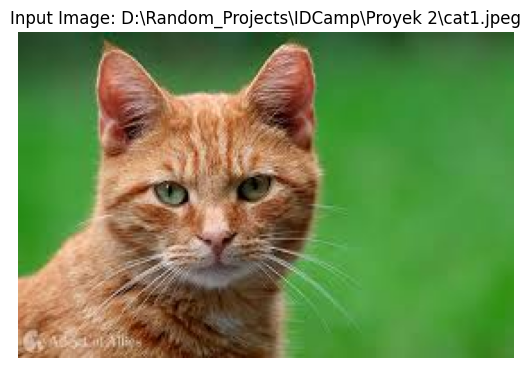

Image: D:\Random_Projects\IDCamp\Proyek 2\cat1.jpeg
Predicted Class: cat (Confidence: 100.00%)
----------------------------------------


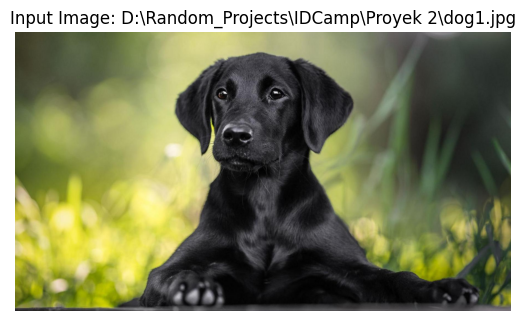

Image: D:\Random_Projects\IDCamp\Proyek 2\dog1.jpg
Predicted Class: dog (Confidence: 100.00%)
----------------------------------------


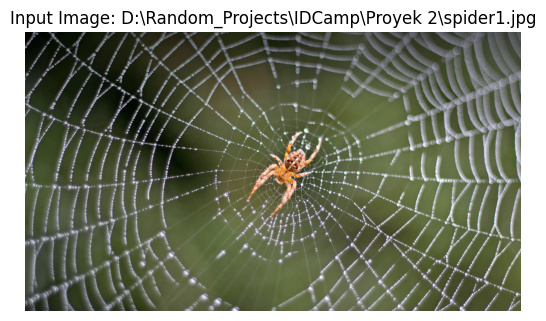

Image: D:\Random_Projects\IDCamp\Proyek 2\spider1.jpg
Predicted Class: spider (Confidence: 100.00%)
----------------------------------------


In [20]:
#TFLite
tflite_model_path = r"D:\Random_Projects\IDCamp\Proyek 2\tflite\model.tflite"
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']
input_size = (input_shape[1], input_shape[2])

label_file_path = r"D:\Random_Projects\IDCamp\Proyek 2\tflite\label.txt"
with open(label_file_path, "r") as f:
    labels = [line.strip() for line in f.readlines()]

image_paths = [
    r"D:\Random_Projects\IDCamp\Proyek 2\cat1.jpeg",
    r"D:\Random_Projects\IDCamp\Proyek 2\dog1.jpg",
    r"D:\Random_Projects\IDCamp\Proyek 2\spider1.jpg"
]

def preprocess_image(image_path, target_size):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

for image_path in image_paths:
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title(f"Input Image: {image_path.split('/')[-1]}")
    plt.show()
    
    input_data = preprocess_image(image_path, input_size)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_class = np.argmax(output_data)
    confidence = np.max(output_data) * 100
    
    print(f"Image: {image_path.split('/')[-1]}")
    print(f"Predicted Class: {labels[predicted_class]} (Confidence: {confidence:.2f}%)")
    print("-" * 40)

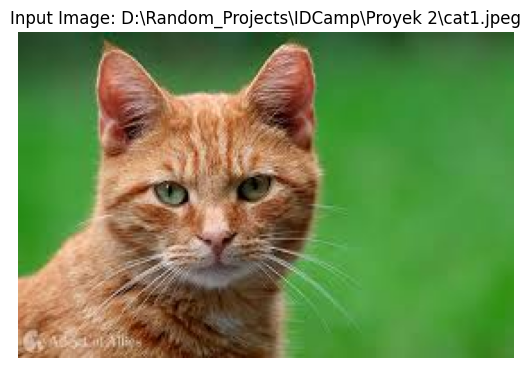

1/1 [==============================] - 1s 788ms/step
Image: D:\Random_Projects\IDCamp\Proyek 2\cat1.jpeg
Predicted Class: Cat (Confidence: 100.00%)
----------------------------------------


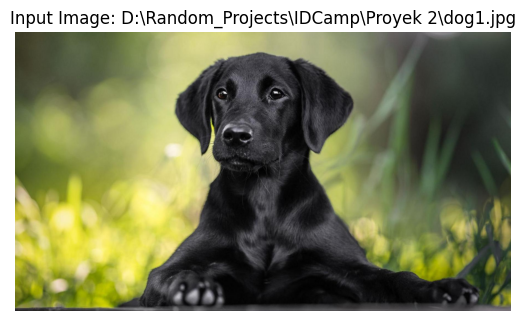

1/1 [==============================] - 0s 29ms/step
Image: D:\Random_Projects\IDCamp\Proyek 2\dog1.jpg
Predicted Class: Dog (Confidence: 100.00%)
----------------------------------------


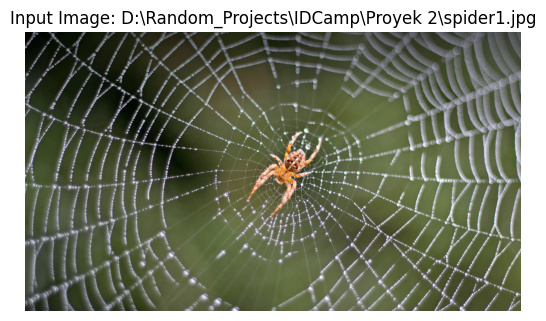

1/1 [==============================] - 0s 37ms/step
Image: D:\Random_Projects\IDCamp\Proyek 2\spider1.jpg
Predicted Class: Spider (Confidence: 100.00%)
----------------------------------------


In [21]:
#Saved Model
saved_model_path = r"D:\Random_Projects\IDCamp\Proyek 2\saved_model"
model = tf.keras.models.load_model(saved_model_path)
labels = ["Cat", "Dog", "Spider"]

image_paths = [
    r"D:\Random_Projects\IDCamp\Proyek 2\cat1.jpeg",
    r"D:\Random_Projects\IDCamp\Proyek 2\dog1.jpg",
    r"D:\Random_Projects\IDCamp\Proyek 2\spider1.jpg"
]
input_shape = model.input_shape
input_size = (input_shape[1], input_shape[2])

for image_path in image_paths:
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title(f"Input Image: {image_path.split('/')[-1]}")
    plt.show()

    input_data = preprocess_image(image_path, input_size)
    output_data = model.predict(input_data)
    predicted_class = np.argmax(output_data)
    confidence = np.max(output_data) * 100  
    print(f"Image: {image_path.split('/')[-1]}")
    print(f"Predicted Class: {labels[predicted_class]} (Confidence: {confidence:.2f}%)")
    print("-" * 40)